
## *Outlier Detection Using Statistical Methods*, 

A common data issue you may face is the presence of **outliers**. Outliers can be point outliers, collective outliers, or contextual outliers. For example, a **point outlier** occurs when a data point deviates from the rest of the population—sometimes referred to as a **global outlier**. 

**Collective outliers**, which are groups of observations, differ from the population and don't follow the expected pattern. Lastly, **contextual outliers** occur when an observation is considered an outlier based on a particular condition or context, such as deviation from neighboring data points. Note that with contextual outliers, the same observation may not be considered an outlier if the context changes.

You will be introduced to a handful of practical statistical techniques that 
cover parametric and non-parametric methods, where we cover statistical methods for **outlier** and **anomaly** detection. 

In the literature, you will find another popular term, **anomaly detection**, which can be synonymous with **outlier detection**. The methods and techniques to identify outlier or anomaly observations are similar; the difference lies in the context and the actions that follow once these points have been identified. 

For example, an outlier transaction in financial transactions may be referred to as an anomaly and trigger a fraud investigation to stop them from re-occurring. Under a different context, survey data with outlier data 
points may simply be removed by the researchers once they examine the overall impact of keeping versus removing such points. Sometimes you may decide to keep these outlier points if they are part of the natural process. In other words, they are legitimate and opt to use robust statistical methods that are not influenced by outliers. 

These practical yet straightforward techniques are easy to interpret and implement. 

The methods that we will encounter are as follows:  
* Resampling time series data
* Detecting outliers using visualizations
* Detecting outliers using the Tukey method
* Detecting outliers using a z-score
* Detecting outliers using a modified z-score

## Datasets:
We use data from the **Numenta Anomaly Benchmark (NAB)**  (https://github.com/numenta/NAB), which provides outlier detection benchmark datasets, to evaluate different **anomaly detection** algorithms.

e.g.: The *New York Taxi dataset* captures the number of NYC taxi passengers at a specific timestamp. The data contains known anomalies that are provided to evaluate the performance of our outlier detectors. The dataset contains 10,320 records between July 1, 2014, to May 31, 2015. The observations are captured in a 30-minute interval, which translates to freq = '30T'.


To prepare for the outlier detection methods, start by loading the libraries that you will be using throughout:

# Technical Requirements 
* Preparing the libraries

In [76]:
# Pip install example
!pip install matplotlib --quiet
!pip install pandas --quiet
!pip install scipy --quiet
!pip install statsmodels --quiet

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#----------------------------------------#
import warnings, scipy, statsmodels
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = 16, 3

### Create DataFrames 
Load the `nyc_taxi.csv` data into a pandas DataFrame as it will be used throughout:

In [78]:
file = "https://raw.githubusercontent.com/FuTSA23/time-series-analysis-datasets/main/nyc_taxi.csv"
nyc_taxi = pd.read_csv(file,
                    index_col='timestamp',
                    parse_dates=True)

nyc_taxi.index.freq = '30T'

### Visualize DataFrames

* **nyc_taxi.csv**: Number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

The New York Taxi dataset captures the number of NYC taxi passengers at a specific timestamp. The data contains known anomalies that are provided to evaluate the performance of our outlier detectors. The dataset contains 10,320 records between July 1, 2014, to May 31, 2015. The observations are captured in a 30-minute interval, which translates to freq = '30T'.

In [79]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq='30T')

You can store the known dates containing outliers, also known as **ground truth labels** which we will use later for analysis of our models. 

In [80]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

If you investigate these dates to gain more insight into their significance, you will find similar information to the following summary:
* Saturday, November 1, 2014, was before the New York Marathon, and the official marathon event was on Sunday, November 2, 2014.
* Thursday, November 27, 2014, was Thanksgiving Day.
* Thursday, December 25, 2014, was Christmas Day.
* Thursday, January 1, 2015, was New Year's Day.
* Tuesday, January 27, 2015, was the North American Blizzard where all vehicles were ordered off the street from January 26 to January 27, 2015.

<Axes: title={'center': 'NYC Taxi'}, xlabel='timestamp'>

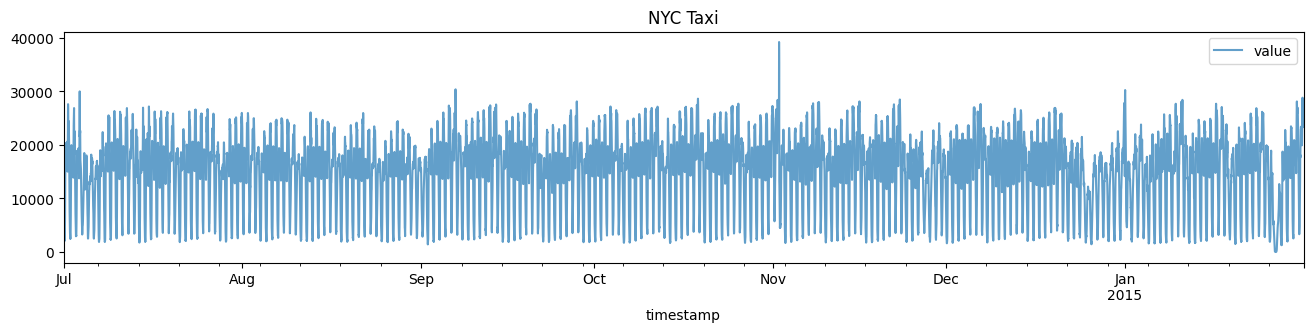

In [81]:
nyc_taxi.plot(title="NYC Taxi", alpha=0.7)

Finally, create the `plot_outliers function` that you will use throughout:


In [82]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right', 
                 valignment = 'bottom',
                 labels=False):

    ax = data.plot(alpha=0.6)
    
    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'rx')
            plt.text(i[0], i[1], f'{i[0].date()}', 
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rx')
        
    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('# of passengers')
    plt.legend(['nyc taxi','outliers'])
    plt.show()

As we proceed with the outlier detection techniques, the goal is to see how the different techniques capture outliers and compare them to the **ground truth labels**

# Understanding Outliers:
+ Outliers require special handling and investigation before deciding how to handle them.
+ Detecting and identifying outliers is crucial, and domain knowledge can help determine their impact and how to deal with them.
+ Outliers can indicate bad data, errors, faulty sensors, bad experiments, or natural variation.
+ Outliers can be undesirable if they seem synthetic, but may be necessary to keep if they are a natural part of the process.
+ Generally, outliers can cause side effects when building a model based on strong assumptions on the data distribution; for example, the data is from a Gaussian (normal) distribution. Statistical methods and tests based on assumptions of the underlying distribution are referred to as parametric methods. Parametric methods make assumptions about the data distribution and can be affected by outliers.
+ There is no fixed protocol for dealing with outliers, and their impact varies, so domain knowledge is essential.
+ Spotting outliers is usually part of the data cleansing and preparation process before analysis.
+ Outliers can be removed, replaced, or smoothed to minimize their impact, or resilient algorithms can be used to their effect.
+ A common approach is to delete outliers and not have them be part of the analysis or model development or replace them using imputation and interpolation techniques.
+ Smoothing techniques like exponential smoothing can also be used to minimize the impact of outliers.
+ Outliers can also be kept and used with more resilient algorithms.


In statistical methods, you have different tools that you can 
leverage, such as the use of visualizations (boxplots, QQ-plots, histograms, and scatter plots), z-score, **interquartile range (IQR)** and Tukey fences, and statistical tests such as Grubb's test, the Tietjen-Moore test, or the generalized **Extreme Studentized Deviate (ESD)** test.

# 1. Resampling Time Series Data:
Before diving into outlier detection, you will be introduced to a crucial time series transformation technique known as resampling. The process implies changing the frequency or level of granularity of the data. 

Usually, you will have limited control over how the time series is generated in terms of frequency. For example, the data can be generated and stored in small intervals, such as milliseconds, minutes, or hours. In some cases, the data can be in larger intervals, such as daily, weekly, or monthly.

## Downsampling & Upsampling:
The need for resampling time series can be driven by the nature of your analysis and at what granular level you need your data to be. 

For instance, you can have daily data, but your analysis requires the data to be weekly, and thus you will need to resample. This process is known as downsampling. When you are downsampling, you will need to provide some level of aggregation, such as mean, sum, min, or max, to name a few.

On the other hand, some situations require you to resample your data from daily to hourly. This process is known as upsampling. When upsampling, you will have null rows, which you must fill either using imputation or interpolation techniques

### How to do it?

The nyc_taxis data captures the number of passengers in 
30-minute intervals.

### 1. DOWNSAMPLING:
Downsample the data to a daily frequency. Currently, you have 10,320 records, 
and when you resample the data to daily, you will need to aggregate the data. In this example, you will use the `.mean()` function. This will reduce the number of samples to 215 records, hence the name downsampling (the number of samples 
went down).

In [83]:
# BEFORE DOWNSAMPLING:
nyc_taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


Resampling is done using the `DataFrame.resample()` function. For daily, 
you will use 'D' as the date offset rule, followed by `.mean()`

In [84]:
nyc_down = nyc_taxi.resample('D').mean()
nyc_down.head()

,value
timestamp,
2014-07-01,15540.979167
2014-07-02,15284.166667
2014-07-03,14794.625000
2014-07-04,11511.770833
2014-07-05,11572.291667


Notice how DatetimeIndex is now at a daily frequency, and the number of 
passengers now reflects the daily average. Inspect the first DatetimeIndex to 
check its frequency:

In [85]:
print("Downsampled Frequency : {}".format(nyc_down.index.freq))
print("No. of records after downsamplings : {}".format((nyc_down.shape)[0]))

Downsampled Frequency : <Day>
No. of records after downsamplings : 215


In [86]:
known_outliers = nyc_down.loc[nyc_dates]

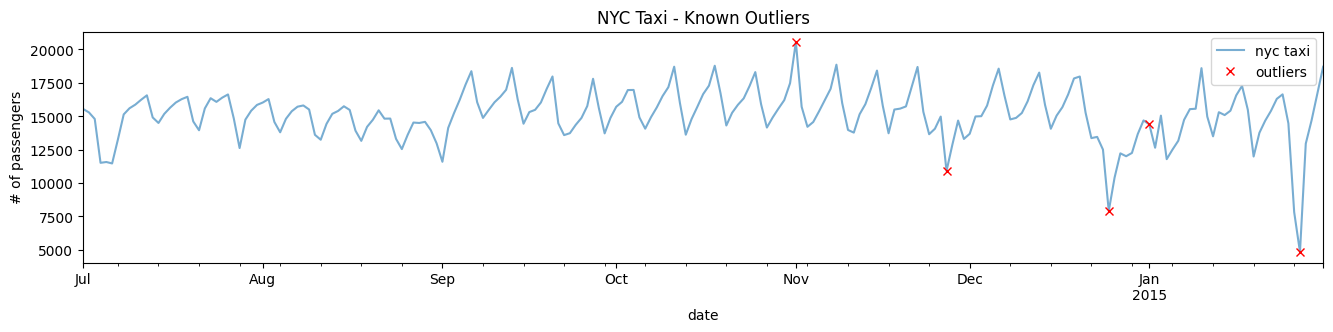

In [87]:
plot_outliers(known_outliers, nyc_down, 'Known Outliers')

#### Q1. Resampling Time Series Data
<font color='red'>
Resample the above data one more time, but this time as a 3-day frequency. You can do this by using '3D'. This time, use the .sum() method instead of .mean() as the aggregator.
</font>


### 2. UPSAMPLING:
Let's upsample the data from a 30-minute interval (frequency) to 
a 15-minutes frequency. This will create an empty entry (NaN) between every other entry. 

`You will use 'T' for minutes, since 'M' is used for monthly aggregation.`
Notice that upsampling creates NaN rows. Unlike downsampling, when upsampling, 
you need to give instructions on how to fill the NaN rows. You might be wondering why we used `.mean()` here? The simple answer is because it would not matter whether you used `.sum()`, `.max()`, or `.min()`, for example. You will need to augment the missing rows using `imputation` or `interpolation` techniques when you `upsample`. For example, you can specify an imputation method in `.fillna()` or by using the shortcut methods such as `.ffill()` or `.bfill()`. 


In [88]:
nyc_taxi.resample('15T').mean().head()

,value
timestamp,
2014-07-01 00:00:00,10844.0
2014-07-01 00:15:00,NaN
2014-07-01 00:30:00,8127.0
2014-07-01 00:45:00,NaN
2014-07-01 01:00:00,6210.0


The `DataFrame.resample()` method allows you to group rows in a specified time 
frame, for example, by day, week, month, year, or any DateTime attribute. The way `.resample()` works is by grouping the data using the `DatetimeIndex` and the frequency provided, hence, this method is specific to time series `DataFrames`. 

The `.resample()` function works in a very similar manner to the `.groupby()`
function; the difference is that `.resample()` is specific to time series data and groups at the DatetimeIndex.


In [89]:
nyc_taxi.resample('15T').fillna('ffill').head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


In [90]:
nyc_taxi.resample('15T').ffill().head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:15:00,10844
2014-07-01 00:30:00,8127
2014-07-01 00:45:00,8127
2014-07-01 01:00:00,6210


## There is more...
You can supply more than one aggregation at once when downsampling using the 
`.agg()` function. 
For example, using `'M'` for monthly, you can supply the `.agg()` function with a list of aggregations you want to perform. 

Notice that the default behavior for 'M' or monthly frequency is at the month's end (example 2014-07-31). You can change to month's start instead by using 'MS'. For example, this will produce 2014-07-01 instead (the beginning of each month).

This should produce a DataFrame with five columns, one for each aggregation method specified. The index column, a timestamp column, will be grouped at monthly intervals:

In [91]:
nyc_taxi.resample('MS').agg(['mean', 'min', 
                            'max', 'median', 'sum'])

value                                
                    mean   min    max   median       sum
timestamp                                               
2014-07-01  14994.084677  1769  29985  16625.5  22311198
2014-08-01  14580.438844  1841  26062  16184.0  21695693
2014-09-01  15623.374306  1431  30373  17244.5  22497659
2014-10-01  16086.851478  1691  28626  17767.5  23937235
2014-11-01  15492.125000  1683  39197  17287.0  22308660
2014-12-01  14813.428763  1459  27804  16587.0  22042382
2015-01-01  14399.790995     8  30236  16061.0  21426889

To learn more about pandas DataFrame.resample(), please visit the official 
documentation here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

# 2. Detecting Outliers using Visualization

There are two general approaches for using statistical techniques to detect outliers: **parametric** and **non-parametric** methods. Parametric methods assume you know the underlying distribution of the data. For example, if your data follows a normal distribution. On the other hand, in non-parametric methods, you make no such assumptions. 

Using histograms and box plots are basic non-parametric techniques that can provide insight into the distribution of the data and the presence of outliers.

 More specifically, box plots, also known as **box and whisker plots**, provide a five-number summary: the minimum, first quartile (25th percentile), median (50th percentile), third quartile (75th percentile), and the maximum.

 There are different implementations for how far the whiskers extend, for example, the whiskers can extend to the minimum and maximum values.
 
  In most statistical software, including Python's matplotlib and  seaborn
libraries, the whiskers extend to what is called **Tukey's lower and upper fences.**Any data point outside these boundaries is considered an outlier. You will dive into the actual calculation and implementation in the Detecting outliers using the Tukey method recipe.

For now, let's focus on the visualization aspect of the analysis.


* You will be using the nyc_taxi DataFrame that you loaded earlier in the Technical requirements section. 
* You will be using seaborn version 0.11.2, which is the latest version as of this writing.

    * To install seaborn using `pip`, use the following: 
    
    
    ```
    pip install seaborn
    ```


Start by importing the seaborn library to begin exploring how these plots work to 
help you detect outliers:

In [92]:
!pip install seaborn --quiet
import seaborn as sns
sns.__version__

'0.12.2'

Recall the nyc_taxi DataFrame contains passenger counts 
recorded every 30 minutes. Keep in mind that every analysis or investigation is 
unique and so should be your approach to align with the problem you are solving 
for. This also means that you will need to consider your data preparation approach, 
for example, determine what transformations you need to apply to your data.

Your goal is to find which days have outlier observations, not at 
which interval within the day, so you will resample the data to a daily frequency. 
You will start by downsampling the data using the mean aggregation. Even though 
such a transformation will smooth out the data, you will not lose too much of the 
detail as it pertains to finding outliers since the mean is very sensitive to outliers. 
In other words, if there was an extreme outlier on a specific interval (there are 48 
intervals in a day), the mean will still carry that information.

In [93]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


Downsample the data to a daily frequency. This will reduce the number of 
observations from 10,320 to 215, or (10320/48 = 215):

In [94]:
tx = nyc_taxi.resample('D').mean()


Plot the new `tx` DataFrame with the `ground truth labels` to use as a reference. 
You will call the `plot_outliers` function. This should produce a time series plot with X markers for known outliers.


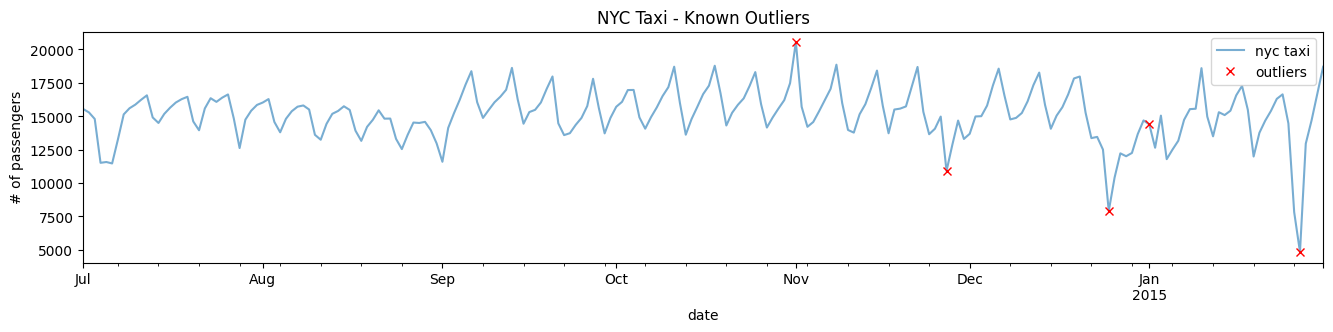

In [95]:
plot_outliers(known_outliers, tx, 'Known Outliers')

## Histogram

Now, let's start with your first plot for inspecting your time series data using the 
histplot() function:

<Axes: ylabel='Count'>

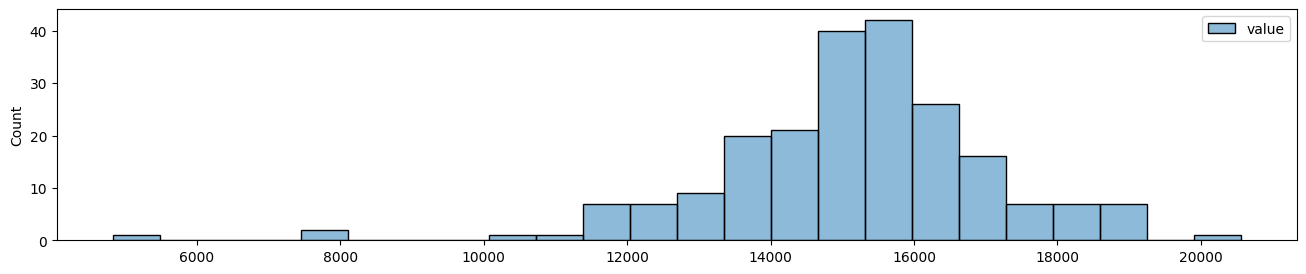

In [96]:
sns.histplot(tx)

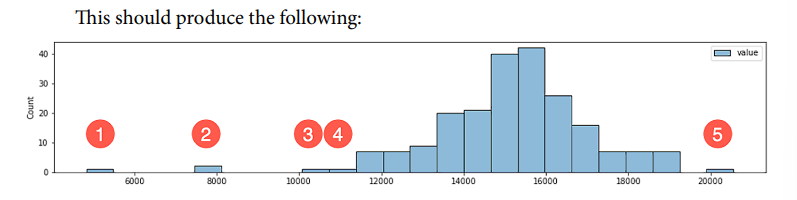

The observations labeled as 1, 2, 3, 4, and 5 seem to represent extreme
passenger values. Recall, these numbers represent the average daily passengers 
after resampling. 

The question you should ask is whether these observations are 
outliers. The center of the histogram is close to 15,000 daily average passengers. 

This should make you question whether the extreme value close to 20,000 (label 
5) is that extreme. Similarly, the observations labeled 3 and 4 (since they are close 
to the tail of the distribution), are they actually extreme values? How about labels 
1 and 2 with average passenger rides at 3,000 and 8,000 daily average passengers 
respectively? 

These do seem more extreme compared to the rest and may potentially 
be actual outliers. Again, determining what is an outlier and what is not requires 
domain knowledge and further analysis.

 There is no specific rule, and you will see 
throughout this chapter that some of the generally accepted rules are arbitrary and 
subjective. You should not jump to conclusions immediately. 


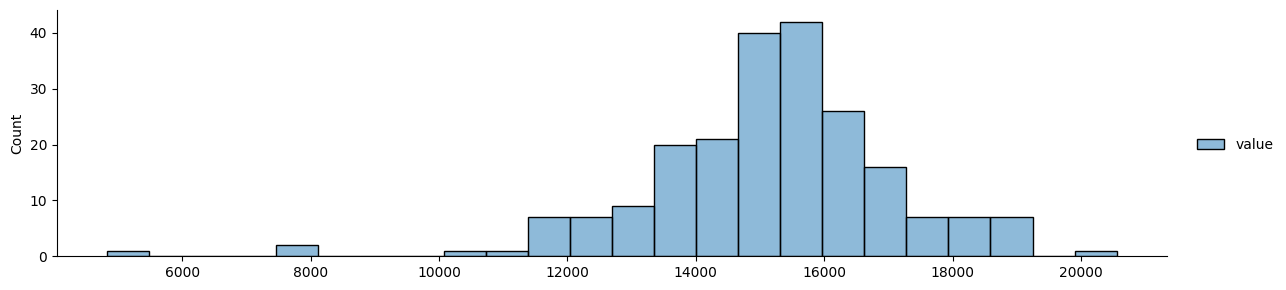

In [97]:
# Similar plot can be achieved by displot()
sns.displot(tx, kind='hist', height=3, aspect=4)

`displot()` has a `kind` parameter. The 
kind parameter can take one of three values: `hist` for the `histogram plot`, `kde` for 
the `kernel density estimate` plot, and `ecdf` for the `empirical cumulative distribution 
function` plot.

## Box Plot

* A box plot provides more information than a histogram and can be a better choice 
for spotting outliers. 
* In a box plot, observations that are outside the whiskers
or boundaries are considered outliers. The whiskers represent the visual boundary 
for the upper and lower fences as proposed by mathematician John Tukey in 1977.

<Axes: xlabel='value'>

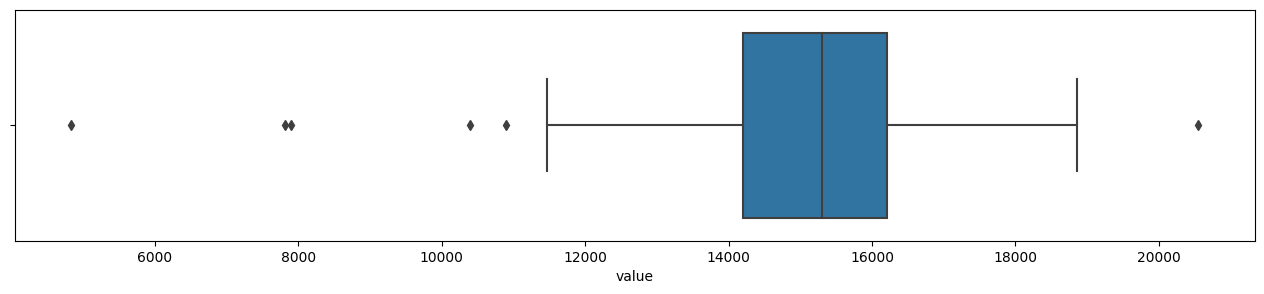

In [98]:
sns.boxplot(x=tx['value'], whis=1.5)

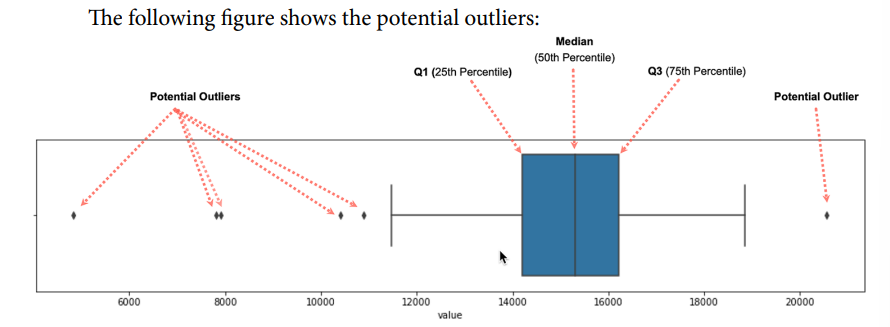

The width of the box `(Q1 to Q3)` is called `interquartile range (IQR)` calculated as 
the difference between the 75th and 25th percentiles (Q3 – Q1). 

The lower fence 
is calculated as `Q1 - (1.5 x IQR)`, and the upper fence as `Q3 + (1.5 x IQR)`. 

Any 
observation less than the lower boundary or greater than the upper boundary is 
considered a potential outlier. More on that in the Detecting outliers using the Tukey 
method.

The whis parameter in the boxplot function is set to 1.5 by 
default (1.5 times IQR), which controls the width or distance between the upper 
and lower fences.

Larger values mean fewer observations will be deemed as outliers, 
and smaller values will make non-outlier points seem outside of boundaries 
(more outliers)

<Axes: xlabel='value'>

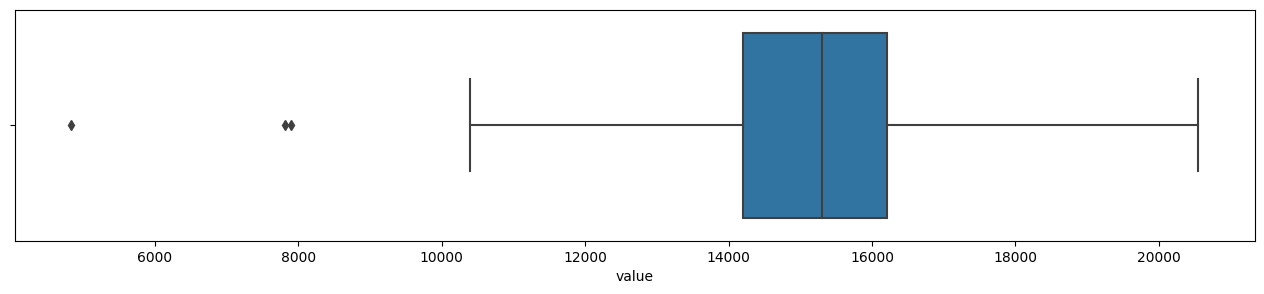

In [99]:
sns.boxplot(x=tx['value'], whis=2.5)
# By changing the values of whis we can adjust our tolerace towards outliers. 

# Percentile Values
Are you wondering how we were able to determine the exact value for the 25th, 
50th, and 75th percentiles? 

You can obtain these values for a DataFrame or series with the describe
method. For example, if you run `tx.describe()`, you should see a table of 
descriptive statistics that includes count, mean, standard deviation, minimum, 
maximum, 25th, 50th, and 75th percentile values for the dataset.

In [100]:
tx.describe()

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
25%,14205.197917
50%,15299.937500
75%,16209.427083
max,20553.500000


There are two more variations for box plots in seaborn (**boxenplot** and 
**violinplot**). They provide similar insight as to the boxplot but are presented 
differently. 

The `boxen` plot, which in literature is referred to as a `letter-value` plot, 
can be considered as an enhancement to regular box plots to address some of their 
shortcomings, as described in the paper *Heike Hofmann, Hadley Wickham & Karen Kafadar (2017) Letter-Value Plots: Boxplots for Large Data, Journal of Computational and Graphical Statistics, 26:3, 469-477* 

More specifically, boxen (letter-value) plots 
are better suited when working with larger datasets (higher number of observations 
for displaying data distribution and more suitable for differentiating outlier points 
for larger datasets). The seaborn implementation in boxenplot is based on 
that paper. 

## Boxen Plot (Letter Value)

<Axes: xlabel='value'>

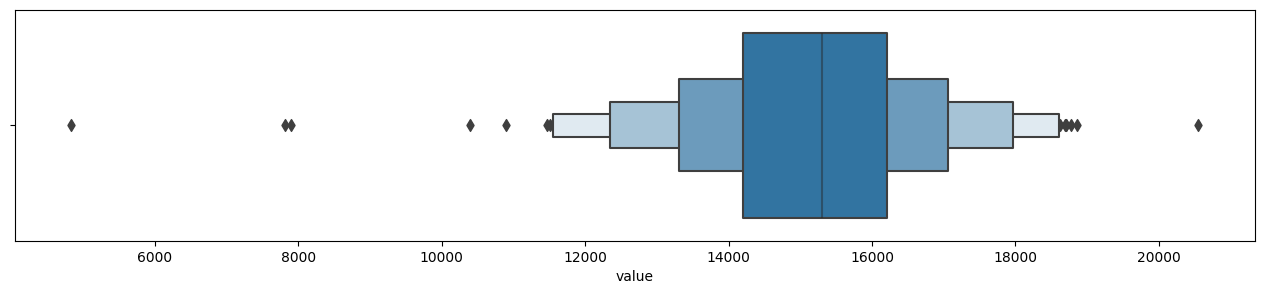

In [101]:
sns.boxenplot(x=tx['value'])

This should produce a plot but with boxes 
extending beyond the quartiles (Q1, Q2, and Q3). The 25th percentile is at the 
14,205 daily average passengers mark, and the 75th percentile is at the 16,209 daily 
average passengers mark.

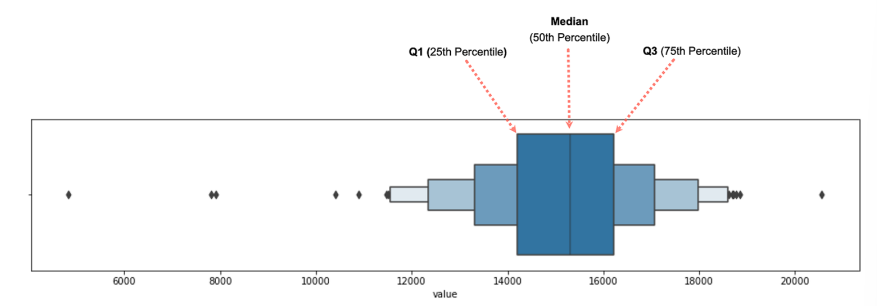


You are getting additional insight into the distribution of passengers 
beyond the quantiles. In other words, it extends the box plot to show additional 
distributions to give more insight into the tail of the data. 

The boxes in theory could 
keep going to accommodate all the data points, but in order to show outliers, there 
needs to be a stopping point, referred to as depth. 

In seaborn, this parameter 
is called `k_depth`, which can take a numeric value, or you can specify different 
methods such as tukey, proportion, trustworthy, or full.

 For example, 
a `k_depth=1` numeric value will show one box.

<Axes: xlabel='value'>

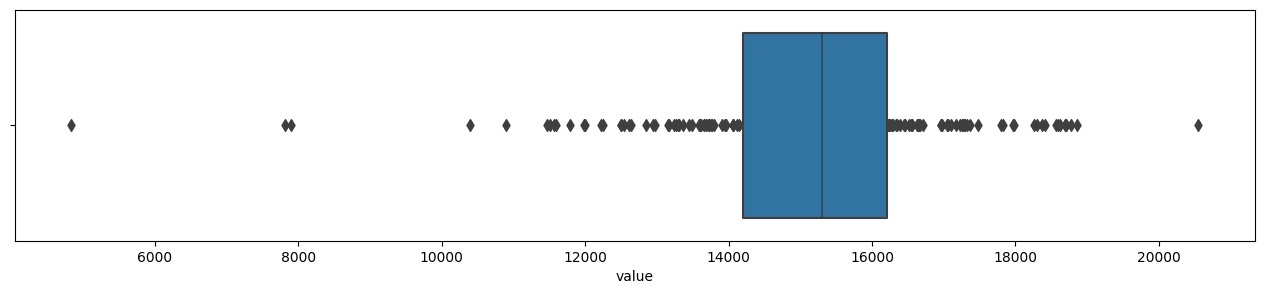

In [102]:
sns.boxenplot(x=tx['value'], k_depth=1) 

<Axes: xlabel='value'>

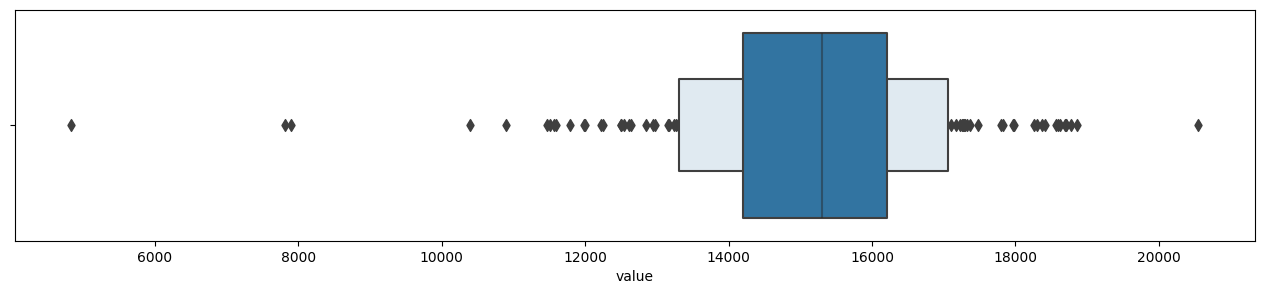

In [103]:
# changing depth with numeric value
sns.boxenplot(x=tx['value'], k_depth=2) 

## Tukey Method: 
For Tukey Method, we use `k_depth = 4` which shows four boxes determined using the `Tukey method`, which is the default value (k_depth="tukey"). 

Using k_depth=4 would produce the same plot as Tukey Method (the default boxenplot method).

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


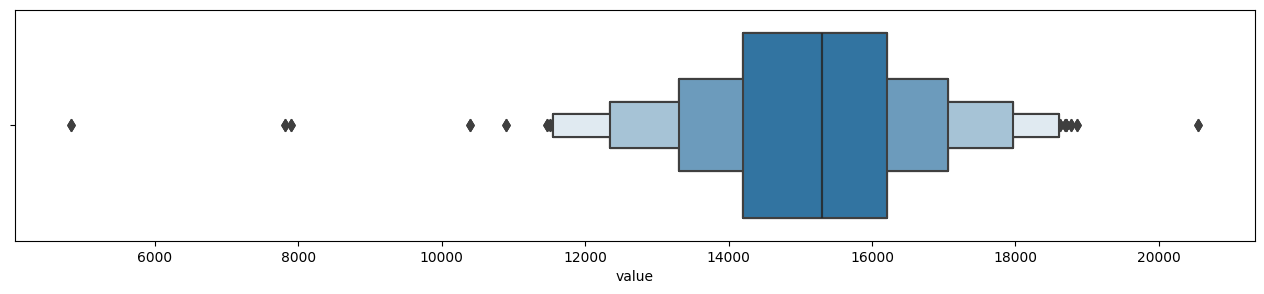

In [104]:
print (sns.boxenplot(x=tx['value'], k_depth="tukey"))
print (sns.boxenplot(x=tx['value'], k_depth=4))
print (sns.boxenplot(x=tx['value']))

# ALL THREE PRODUCE THE SAME PLOTS

 To explore the other different methods, you can try the 
following code:

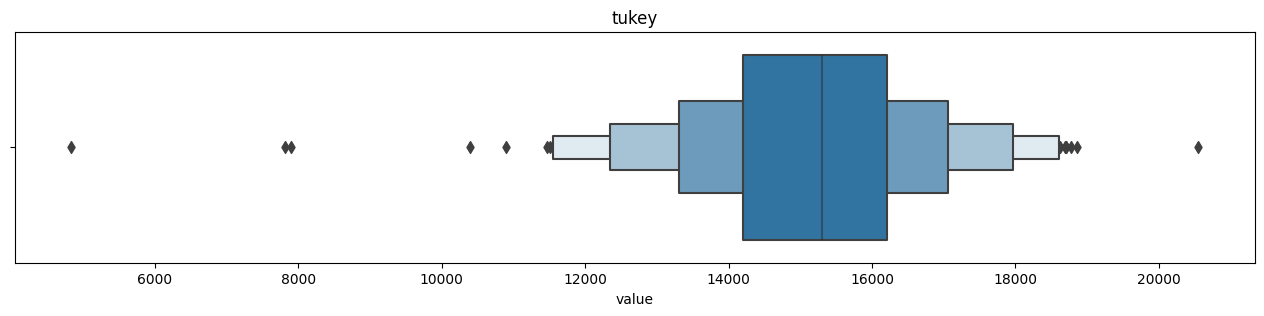

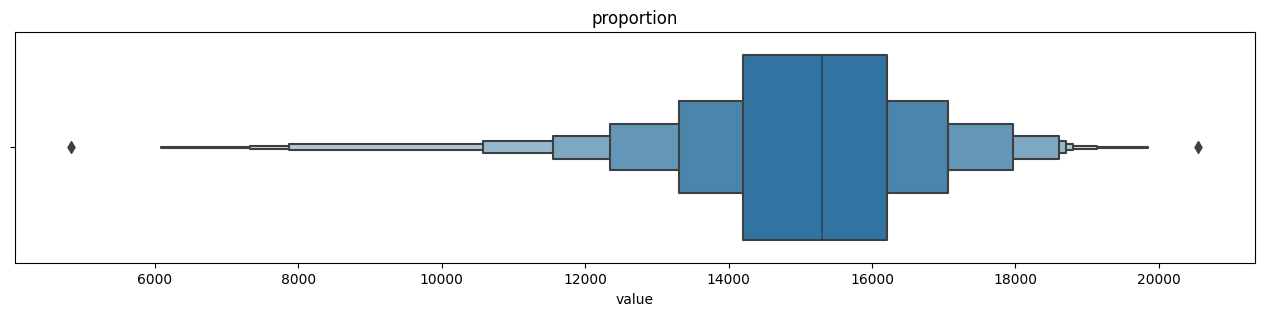

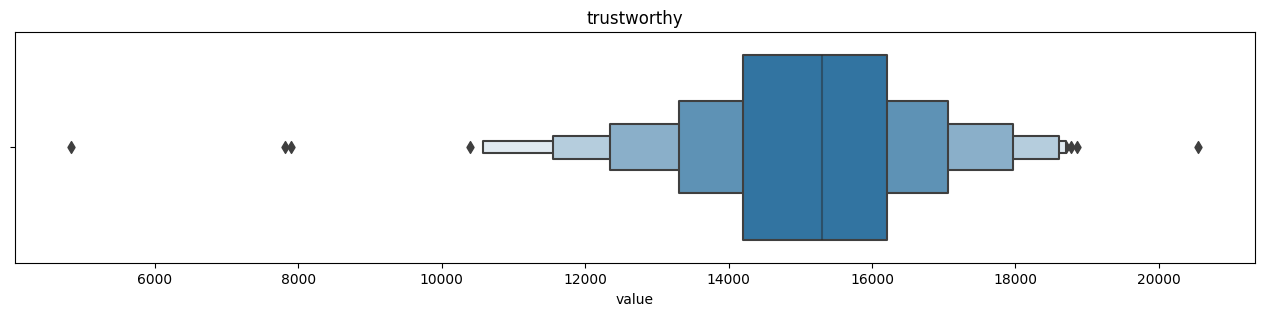

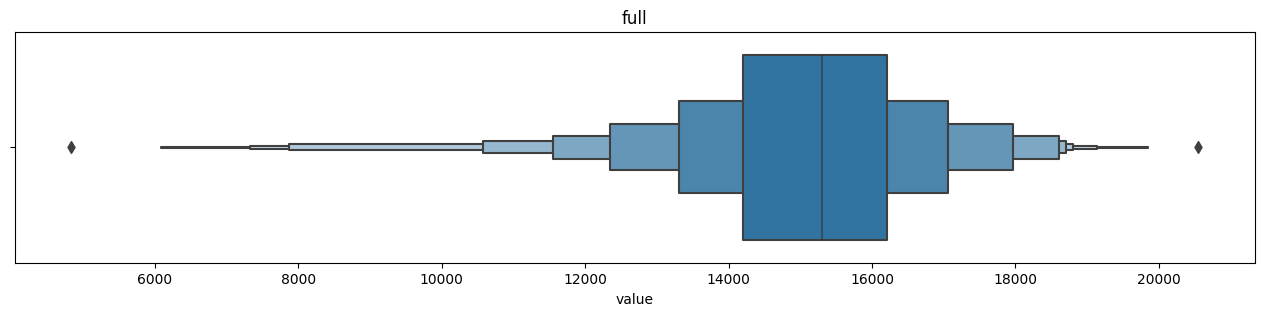

In [105]:
# exploring different methods 
for k in ["tukey", "proportion", "trustworthy", "full"]:
    sns.boxenplot(x=tx['value'], k_depth=k)
    plt.title(k)
    plt.show()

Now, the final variation is the violin plot, which you can display using the 
violinplot function:

## Violin Plot

This should produce a plot that is a **hybrid** between a **box plot** and a **kernel density 
estimation (KDE)**.

A kernel is a function that estimates the probability density 
function, the larger peaks (wider area), for example, show where the majority of 
the points are concentrated.

 This means that there is a higher probability that a data 
point will be in that region as opposed to the much thinner regions showing much 
lower probability.

<Axes: xlabel='value'>

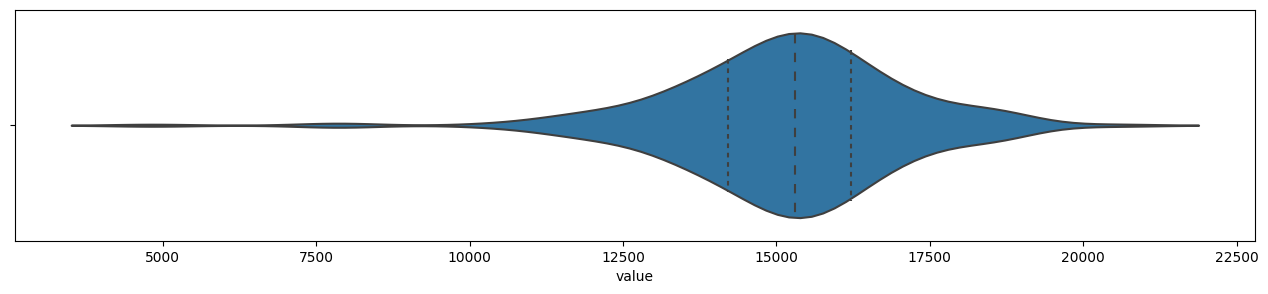

In [106]:
sns.violinplot(x=tx['value'], inner='quartile')

Notice that Figure shows the distribution for the entire dataset. Another observation
is the number of peaks; in this case, we have one peak, which makes it a unimodal 
distribution. 

If there is more than one peak, we call it a multimodal distribution, which 
should trigger a further investigation into the data. A KDE plot will provide similar 
insight as a histogram but with a more smoothed curve.

### Summary

We were introduced to several plots that help visualize the distribution of the 
data and show outliers. 

Generally, histograms are great for showing distribution, but a box 
plot (and its variants) are much better for outlier detection.

 We also explored the boxen 
(letter-value) plot, which is more suited for larger datasets and is more appropriate than regular box plots. 


## BONUS: Lag Plot
* The lag plot is another useful visualization for spotting outliers. A lag plot is essentially 
a scatter plot, but instead of plotting two variables to observe correlation, as an example, 
we plot the same variable against its lagged version. 
* This means, it is a scatter plot 
using the same variable, but the y axis represents passenger count at the current time 
(t) and the x axis will show passenger count at a prior period (t-1), which we call lag. 
* The lag parameter determines how many periods to go back; for example, a lag of 1
means one period back, while a lag of 2 means two periods back. In our resampled data 
(downsampled to daily), a lag of 1 represents the prior day.


In [107]:
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

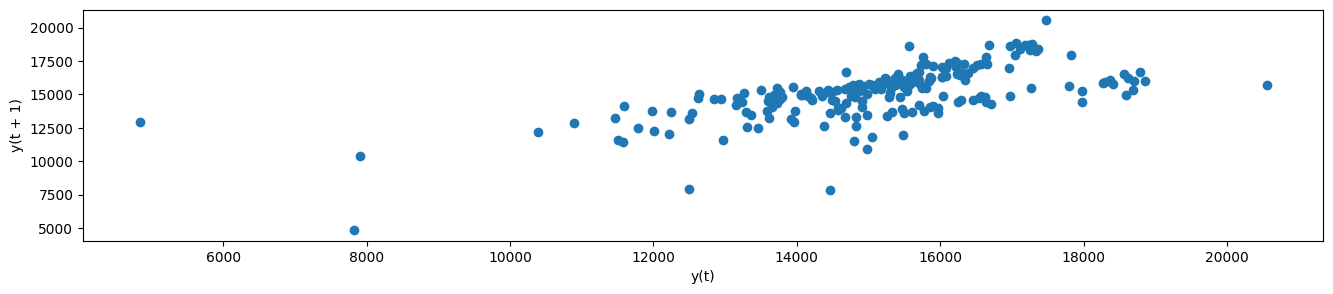

In [108]:
lag_plot(tx, lag=1)

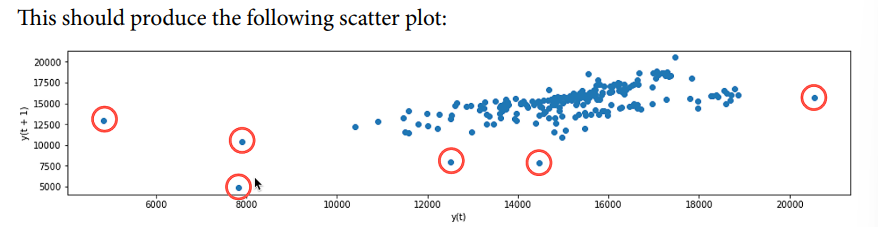

The circled data points highlight interesting points that can be potential outliers. Some 
seem more extreme than others. Further, you can see some linear relationship between 
the passenger counts and its lagged version (prior day) indicating the existence of an 
autocorrelation.

 Recall from basic statistics that correlation shows the relationship 
between two independent variables, so you can think of autocorrelation as a correlation 
of a variable at a time (t) and its prior version at a time (t-1).

Creating a Lag Plot using `seaborn.scatterplot`

<Axes: >

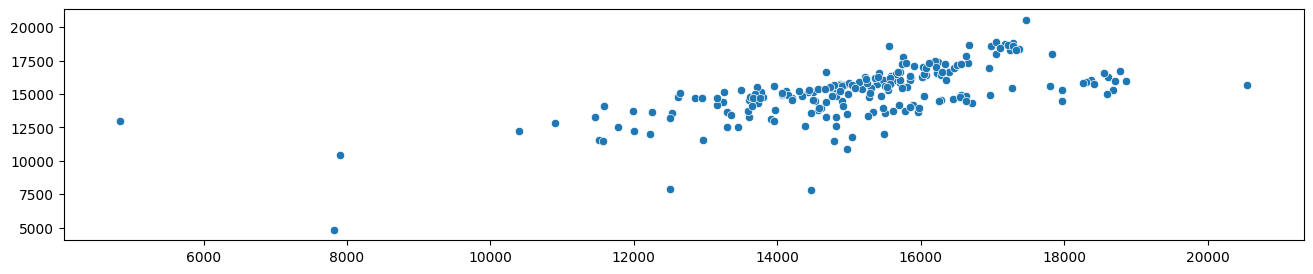

In [109]:
y = tx[1:].values.reshape(-1)
x = tx[:-1].values.reshape(-1)
sns.scatterplot(x=x, y=y)

# 3. Detecting Outliers using Tukey’s Method
We will dive further into **IQR** and **Tukey fences** that we briefly discussed 
when talking about box plots, where we extend the previous method using VISUALISATION. 

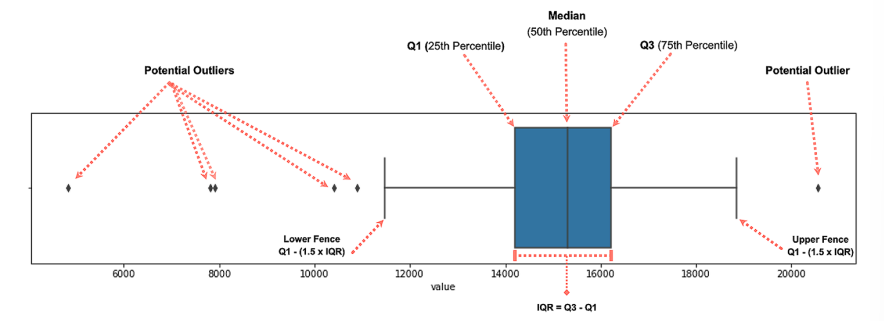

* The box plot showed the quartiles with whiskers extending to the upper 
and lower fences. These boundaries or fences were calculated using the Tukey method.
* Visualizations are great to give you a high-level perspective on the data you are working with, such as the overall distribution and potential outliers. 
* Ultimately you want to identify these outliers programmatically so you can isolate these data points for further investigation and analysis.
* This method will teach how to calculate IQR and define points that fall outside the lower and upper Tukey fences. 

### Method:
Most statistical methods allow you to spot extreme values beyond a certain threshold. For example, this could be the mean, standard deviation, the 10th or 90th percentile, or some other value that you want to compare against. 

We will start by learning how to obtain basic descriptive statistics and more specifically, the quantiles.

## Define the `iqr_outliers` functions

Both `DataFrame` and `Series` have the describe method that outputs summary 
descriptive statistics.

By default, it shows the quartiles: the `first quartile`, which is 
the 25th percentile, the second quartile (median), which is the 50th percentile, and the third quartile, which is the 75th percentile. 

You can customize the percentiles by providing a list of values to the percentiles parameter. The following code 
shows how you can get values for additional percentiles:

In [110]:
percentiles = [0, 0.05, .10, .25, .5, .75, .90, .95, 1]
tx.describe(percentiles= percentiles)

,value
count,215.000000
mean,15137.569380
std,1937.391020
min,4834.541667
0%,4834.541667
5%,11998.181250
10%,13043.854167
25%,14205.197917
50%,15299.937500
75%,16209.427083


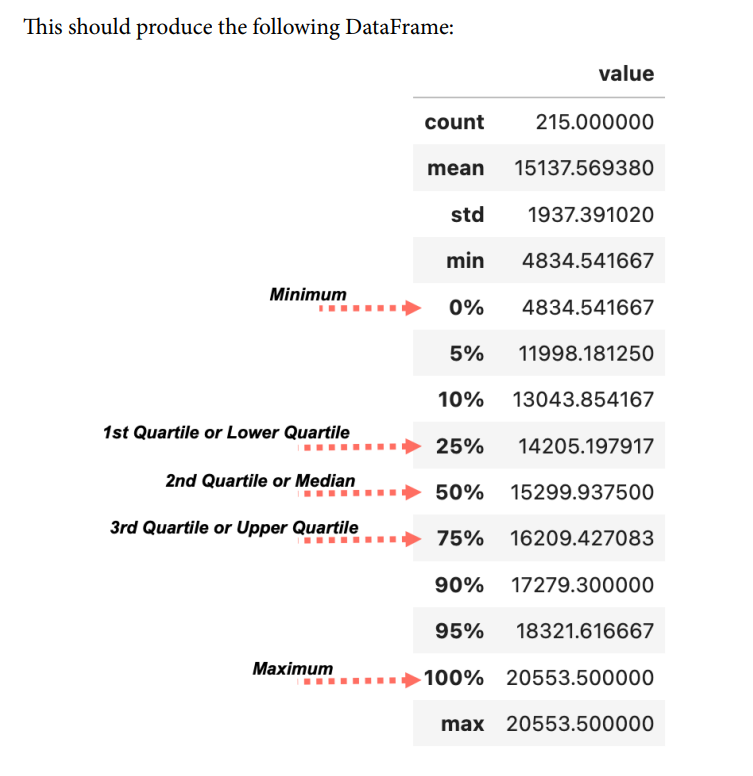


## Quantiles versus Quartiles versus Percentiles
The terms can be confusing, but essentially both percentiles and quartiles are 
quantiles. Sometimes you will see people use percentiles more loosely and 
interchangeably with quantiles. 

Quartiles divide your distribution into four segments (hence the name) 
marked as Q1 (25th percentile), Q2 (50th percentile or Median), and Q3 (75th 
percentile). Percentiles, on the other hand, can take any range from 0 to 100 (in 
pandas from 0 to 1, while in NumPy from 0 to 100), but most commonly refer 
to when the distribution is partitioned into 100 segments. These segments are 
called quantiles.

The names pretty much indicate the type of partitioning (number of quantiles) 
applied on the distribution; for example, with four quantiles we call it quartiles, 
with two quantiles we call it median, with 10 quantiles we call it deciles, and 
with 100 quantiles we call it percentiles.


#### NumPy Implementation
The NumPy library also offers the percentile function, which would return 
the value(s) for the specified percentiles. The following code explains how this can 
be used:

In [111]:
percentiles = [0, 5, 10, 25, 50, 75, 90, 95, 100]
np.percentile(tx, percentiles)

array([ 4834.54166667, 11998.18125   , 13043.85416667, 14205.19791667,
       15299.9375    , 16209.42708333, 17279.3       , 18321.61666667,
       20553.5       ])

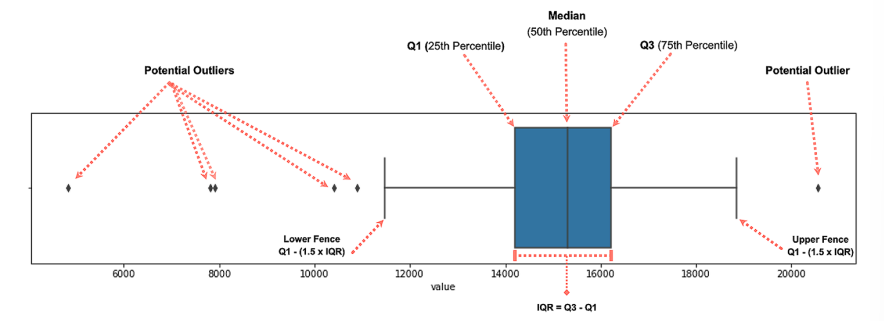

Notice that most extreme values, potential outliers, fall below the 
lower fence calculated as `Q1 – (1.5 x IQR)` or above the upper fence calculated as 
`Q3 + (1.5 x IQR)`. `IQR` is calculated as the difference between `Q3` and `Q1` `(IQR = 
Q3 – Q1)`, which determines the width of the box in the box plot. 

These upper and lower fences are known as **Tukey's fences**, and more specifically, they are referred to as **inner boundaries**. The **outer boundaries** also have lower `Q1 - (3.0 x IQR)` and 
upper `Q3 + (3.0 x IQR)` fences. We will focus on the inner boundaries and describe 
anything outside of those as potential outliers.

In [112]:
def iqr_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (1.5 * IQR)
    upper_fence = q3 + (1.5 * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

In [113]:
outliers = iqr_outliers(tx)
print(outliers)

                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667


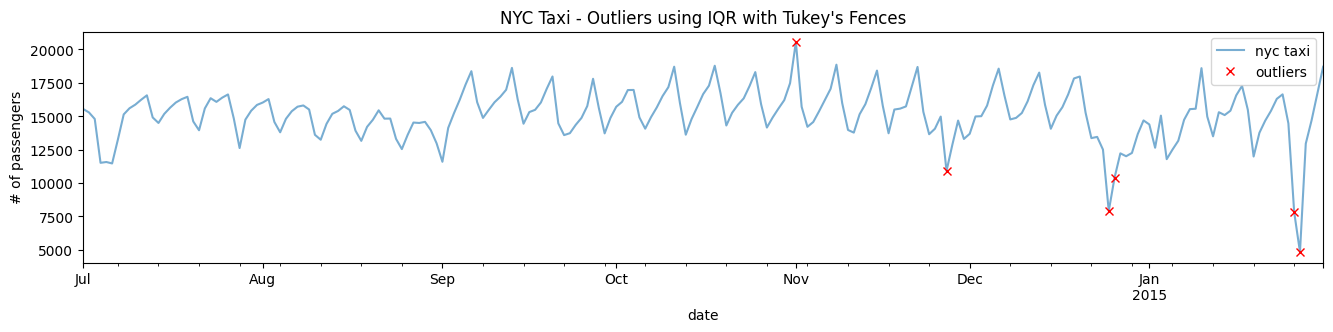

In [114]:
plot_outliers(outliers, tx, "Outliers using IQR with Tukey's Fences")

In [115]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


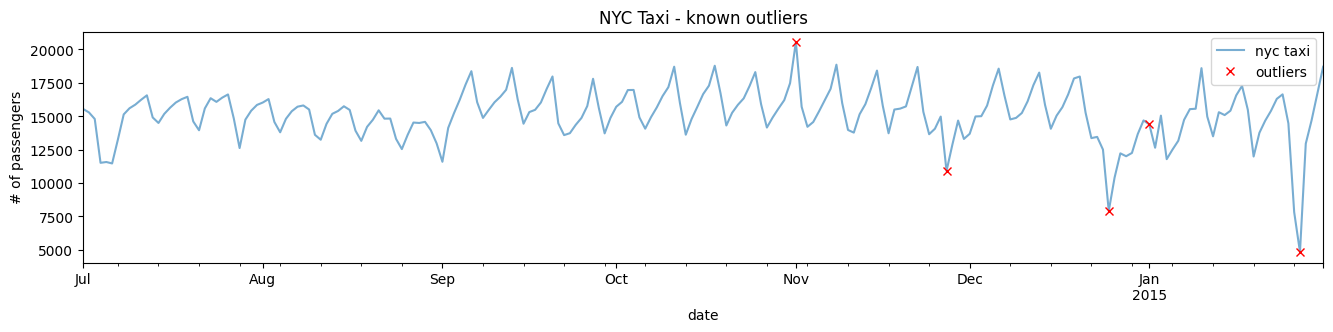

In [116]:
plot_outliers(known_outliers, tx, "known outliers")

You will see that this simple method did a great job at 
identifying four of the five known outliers. In addition, Tukey's method identified two 
additional outliers on 2014-12-26 and 2015-01-26.


Using IQR and Tukey's fences is a simple non-parametric statistical method. Most box 
plot implementations use 1.5x(IQR) to define the upper and lower fences.

## Adjusting the 1.5 factor:
The use of 1.5x(IQR) is common when it comes to defining outliers; the choice is still arbitrary, even though there is a lot of discussion about its reasoning. You can change the value for more experimentation. 

For example, in seaborn, you can change the default 1.5 value by updating the whis parameter in the boxplot function. The choice 
of 1.5 makes the most sense when the data follows a Gaussian distribution (normal), 
but this is not always the case. 

Generally, the larger the value, the fewer outliers you will 
capture as you expand your boundaries (fences). 

Similarly, the smaller the value, the more 
non-outliers will be defined as outliers, as you are shrinking the boundaries (fences).

Let's update the iqr_outliers function to accept a p parameter so you can experiment 
with different values:

In [117]:
def iqr_outliers(data, p):
    q1, q3 = np.percentile(data, [25, 75])
    IQR = q3 - q1
    lower_fence = q1 - (p * IQR)
    upper_fence = q3 + (p * IQR)
    return data[(data.value > upper_fence) | (data.value < lower_fence)]

Run the function on different values: 


In [118]:
for p in [1.3, 1.5, 2.0, 2.5,  3.0]:
    print(f'with p={p}')
    print(iqr_outliers(tx, p))
    print('-'*25)

with p=1.3
                   value
timestamp               
2014-07-04  11511.770833
2014-07-05  11572.291667
2014-07-06  11464.270833
2014-09-01  11589.875000
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
with p=1.5
                   value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
with p=2.0
                   value
timestamp               
2014-11-01  20553.500000
2014-12-25   7902.125000
2015-01-26   7818.979167
2015-01-27   4834.541667
-------------------------
with p=2.5
                  value
timestamp              
2014-12-25  7902.125000
2015-01-26  7818.979167
2015-01-27  4834.541667
-------------------------
with p=3.0
                  value
timestamp             

The best value will depend on your data and how sensitive you need the outlier detection 
to be. 

# 4. Detecting Outliers with Z-score
* What is Z-Score
* Assumptions for Z-Score
* How it is used for Outlier/Anomaly Detection





**Z-Scores**

$$
\Large z = \frac{x - \mu}{\sigma}
$$

In [119]:
def zscore(df, degree=3):
    data = df.copy()
    data['zscore'] = (data - data.mean())/data.std()
    outliers = data[(data['zscore'] <= -degree) | (data['zscore'] >= degree)]
    
    return outliers['value'], data

In [120]:
threshold = 2.5
outliers, transformed = zscore(tx, threshold)

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'zscore'}>]], dtype=object)

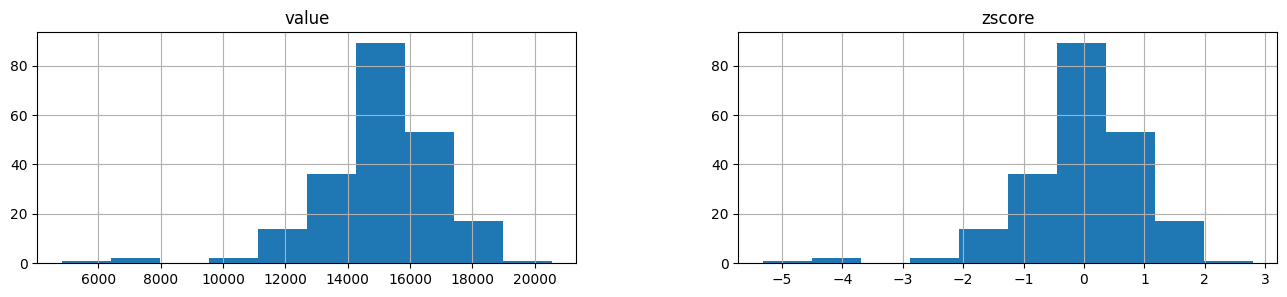

In [121]:
transformed.hist()

In [122]:
known_outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-27,4834.541667


In [123]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


In [124]:
def plot_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

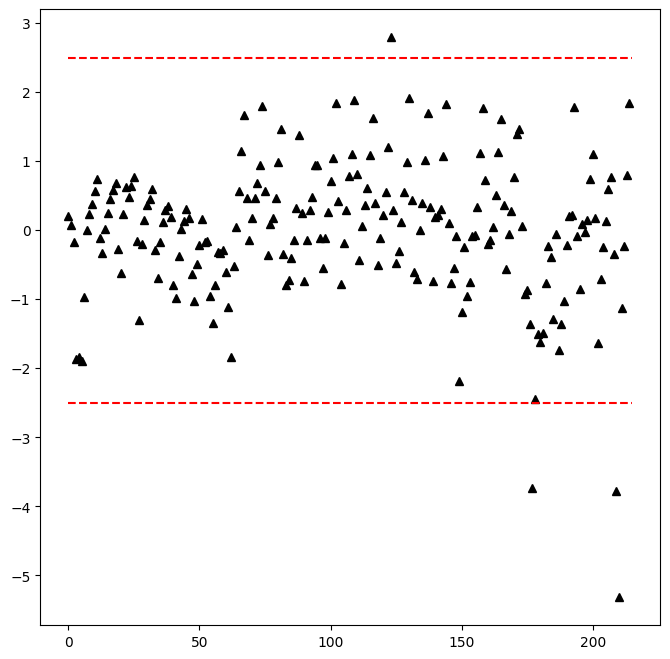

In [125]:
data = transformed['zscore'].values
plot_zscore(data, d=2.5)

In [126]:
outliers

timestamp
2014-11-01    20553.500000
2014-12-25     7902.125000
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64

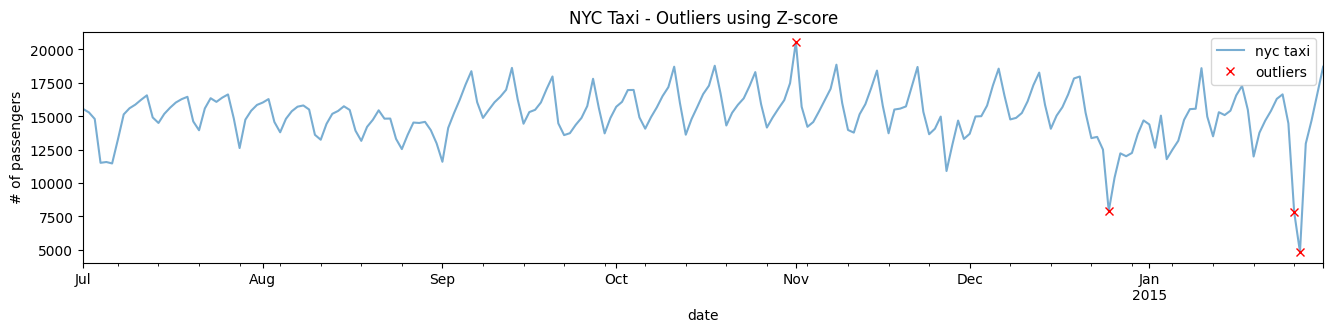

In [127]:
plot_outliers(outliers, tx, 'Outliers using Z-score')

### There is more

In [128]:
from statsmodels.stats.diagnostic import kstest_normal

def test_normal(df):
    t_test, p_value = kstest_normal(df)
    if p_value < 0.05:
        print("Reject null hypothesis. Data is not normal")
    else:
        print("Fail to reject null hypothesis. Data is normal")

In [129]:
test_normal(tx)

Reject null hypothesis. Data is not normal


# Recipe 5. Modified Z-Score
* Understand the difference between Z-Score and Modified Z-Score
* When to use Modified Z-Score (and the assumptions behind Z-score)
* Scipy's Percent Point Function (PPF)

In [130]:
import scipy.stats as stats
stats.norm.ppf(0.75)

0.6744897501960817

In [131]:
def modified_zscore(df, degree=3):
    data = df.copy()
    s = stats.norm.ppf(0.75)
    numerator = s*(data - data.median())
    MAD = np.abs(data - data.median()).median()
    data['m_zscore'] = numerator/MAD
    outliers = data[(data['m_zscore'] > degree) | (data['m_zscore'] < -degree)]
    
    return outliers['value'], data

In [132]:
threshold =  3
outliers, transformed = modified_zscore(tx, threshold)

In [133]:
outliers.shape

(6,)

array([[<Axes: title={'center': 'value'}>,
        <Axes: title={'center': 'm_zscore'}>]], dtype=object)

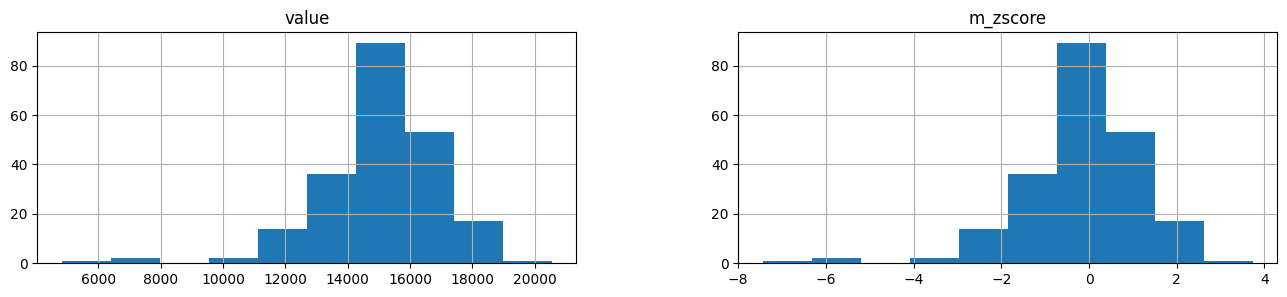

In [134]:
transformed.hist()

In [135]:
print(outliers)

timestamp
2014-11-01    20553.500000
2014-11-27    10899.666667
2014-12-25     7902.125000
2014-12-26    10397.958333
2015-01-26     7818.979167
2015-01-27     4834.541667
Name: value, dtype: float64


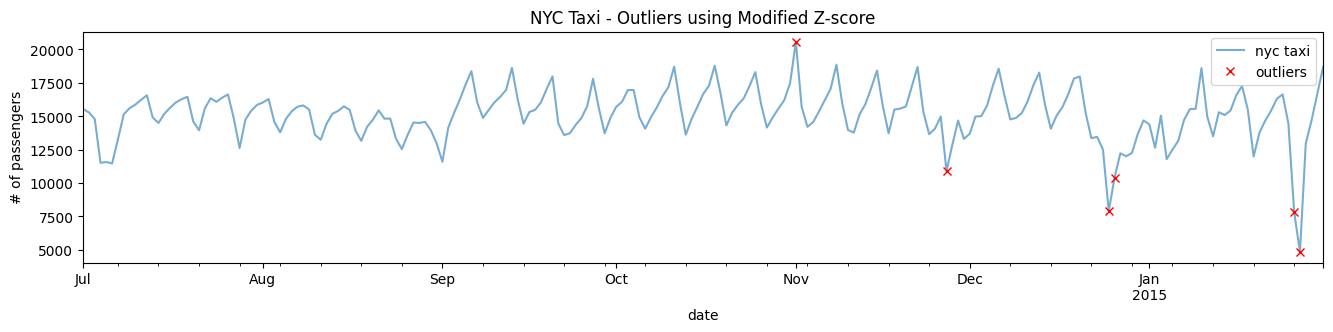

In [136]:
plot_outliers(outliers, tx, 'Outliers using Modified Z-score')

In [137]:
def plot_m_zscore(data, d=3):
    n = len(data)
    plt.figure(figsize=(8,8))
    plt.plot(data,'k^')
    plt.plot([0,n],[d,d],'r--')
    plt.plot([0,n],[-d,-d],'r--')

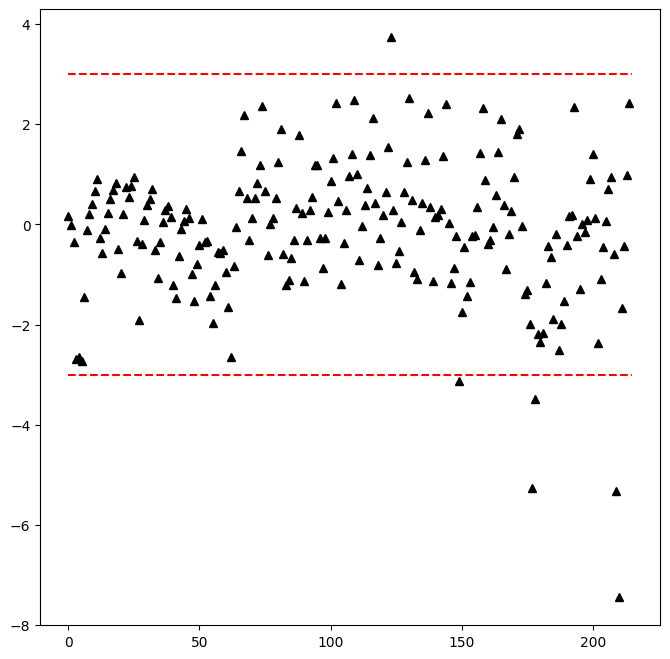

In [138]:
data = transformed['m_zscore'].values
plot_m_zscore(data, d=3)

## There is more

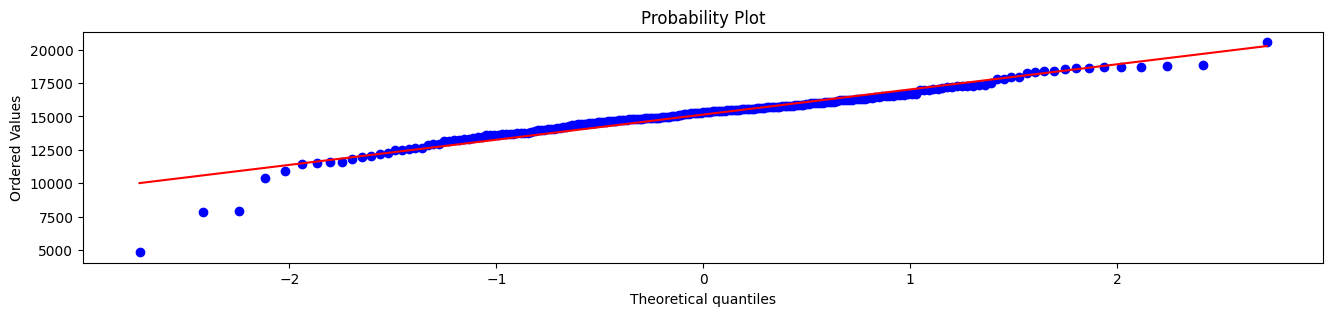

In [139]:
import scipy
import matplotlib.pyplot as plt
res = scipy.stats.probplot(tx.values.reshape(-1), plot=plt)

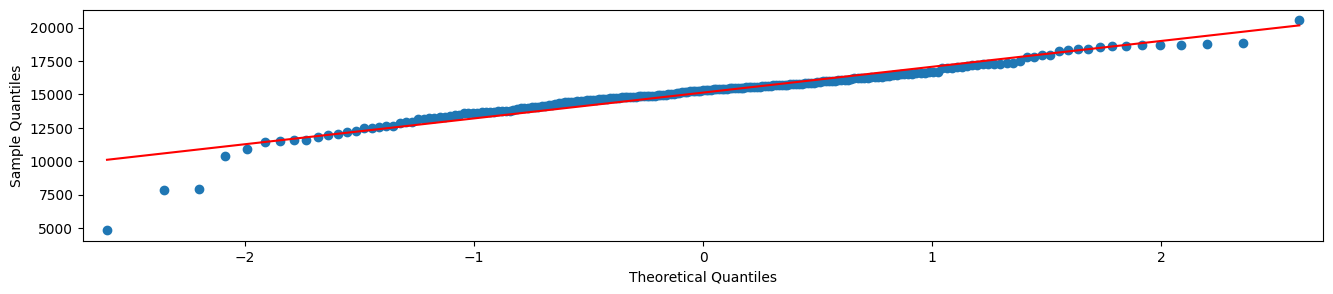

In [140]:
from statsmodels.graphics.gofplots import qqplot
qqplot(tx.values.reshape(-1), line='s');